In [165]:
import re
import os

from bs4 import BeautifulSoup
import pandas as pd
import PyPDF2
import requests
import wget
import urllib.request

%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
#Enlargen
sns.set_context('poster')

plt.style.use('fivethirtyeight')

In [2]:
r = requests.get('https://www.colorado.gov/pacific/revenue/colorado-marijuana-tax-data')
soup = BeautifulSoup(r.text, "lxml")

anchor_tags = soup.findAll('div','fieldset-wrapper')[1].findAll('a')

links = [tag['href'] for tag in anchor_tags]

In [104]:
test_str = '2324245'

In [ ]:
test_str.strip()

In [3]:
def get_year_month(link):
    date_code = os.path.basename(link)[:4]
    date_code = '20{year}-{month}'.format(year=date_code[2:4],month=date_code[0:2])
    return date_code

In [110]:
def extract_df_from_text(text,link):
    county_list_dirty = re.compile(r'[A-Z][a-z]+\s*[A-Z]*[a-z]*').findall(text[text.find('10%'):])
    county_list_dirty = list(set(county_list_dirty)) 
    county_list_dirty = [county.strip() for county in county_list_dirty if county.strip() not in {'Remainder of',
                                                                                                  'Totals', 'State',
                                                                                                 'This represents',
                                                                                                 'of total'}]
    # Note that Routt county is being misspelled as Route in the official docs
    county_list_dirty.extend(('Remainder of State 2/','Remainder of State 1/'))
    counties = county_list_dirty #Dirty no more
    
    county_revenues = []
    for county in counties:
        regex = re.compile(r'{county}\s[\$,0-9\s]+'.format(county=county))
        county_revenues.append(regex.findall(text))
        
    df = pd.DataFrame()

    for revenue in county_revenues:
        for table in revenue:
            county = re.compile(r'[a-zA-Z]+\s*[a-zA-Z]*\s*[a-zA-Z]*').findall(table)[0]
            county = county.strip()
#             if ' '.join(county.split())=='of total':
#                 break
            # Government made a typo we gotta fix!
            if county=='Route':
                county='Routt'
            #Drop single-digit numbers to deal with 'Remainder of State 2/' in some strings
            revenues = re.compile(r'[\$,0-9]{2,20}').findall(table)
            #Medical marijuana table has one value
            if len(revenues)==1:
                df.loc[county,'Medical Marijuana'] = revenues[0]
            #Retail table has two values
            elif len(revenues)==2:
                df.loc[county,'Retail Sales Tax'] = revenues[0]
                df.loc[county,'Additional Retail Sales Tax'] = revenues[1]
                
    df.index.name = 'County'
    df['Month'] = get_year_month(link)
    df['Month'] = pd.DatetimeIndex(df['Month'])
    
    return df.reset_index().set_index(['County','Month'])

In [59]:
def extract_text_from_pdf_at_link(link):
    """
    Return the text from the first--and only, for our initial purposes--page of a pdf file at a given link.
    
    Downloads pdf file if necessary.
    """
    filename = download_if_needed(link)
    with open(filename,'rb') as file:
        pdfReader = PyPDF2.PdfFileReader(file)
        text = pdfReader.getPage(0).extractText()
    text = text.replace('\n',' ')
    irrelevant_text_loc = text.find('Remainder of State is comprised of the following counties')
    text = text[:irrelevant_text_loc+200]
    return text

In [6]:
def download_if_needed(link):
    """
    Download pdf file at link if not already downloaded, returning the filename
    """
    filename = os.path.basename(urllib.request.unquote(link))
    if not os.path.exists(filename):
        #wget needs percent encoding to go away
        wget.download(urllib.request.unquote(link))
    return filename

In [198]:
dfs = []

#Something off with last link
for link in links[0:23]:
    text = extract_text_from_pdf_at_link(link)
    df = extract_df_from_text(text,link)
    dfs.append(df)
    
df = pd.concat(dfs)

for column in df.columns:
    df[column] = [float(str(val).replace('$','').replace(',','')) for val in df[column].values]
    
#Suppress crazy large value for Adams in November 2014 for now
df.loc['Adams']['2014-11-01']['Medical Marijuana'] = 0

In [203]:
df.reset_index(inplace=True)

In [225]:
df.loc[(df['County'] == 'Adams') & [x.strftime('20%y-%m-%d')== '2014-11-01' for x in df['Month']],'Medical Marijuana'] = 0

In [231]:
df.set_index(['County','Month'],inplace=True)

In [142]:
# Odd that the below isn't a constant number
# df['Additional Retail Sales Tax']/df['Retail Sales Tax']

County              Month     
Boulder             2015-01-01    2.962078
San Miguel          2015-01-01    2.769923
Arapahoe            2015-01-01    2.516451
Clear Creek         2015-01-01    2.799015
La Plata            2015-01-01    5.586355
Pitkin              2015-01-01    3.197221
Summit              2015-01-01    2.864164
El Paso             2015-01-01         NaN
Denver              2015-01-01    2.931742
Weld                2015-01-01    2.922124
Gunnison            2015-01-01    2.557466
Eagle               2015-01-01    2.906454
Routt               2015-01-01         NaN
Gilpin              2015-01-01    2.627023
Montezuma           2015-01-01         NaN
Jefferson           2015-01-01    3.150314
Pueblo              2015-01-01    3.415649
Adams               2015-01-01    2.219141
Garfield            2015-01-01    2.942441
Fremont             2015-01-01         NaN
Las Animas          2015-01-01    2.965442
Larimer             2015-01-01    2.980923
Remainder of State  201

In [266]:
addl_series = df['Additional Retail Sales Tax']
addl_series = addl_series.reset_index()
addl_series = addl_series.pivot(index='Month',columns='County',values='Additional Retail Sales Tax').fillna(0)

In [160]:
retail_series = df['Retail Sales Tax']

retail_series = retail_series.reset_index()

In [167]:
retail_series = retail_series.pivot(index='Month',columns='County',values='Retail Sales Tax').fillna(0)

In [179]:
top_ten_counties = retail_series.sum(axis=0).sort_values(ascending=False).index[1:10]

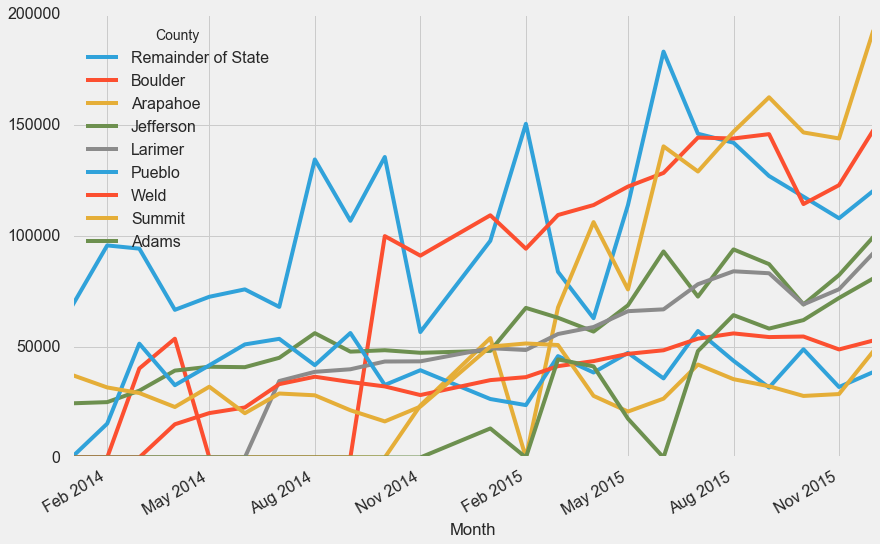

In [234]:
retail_series[top_ten_counties].plot()

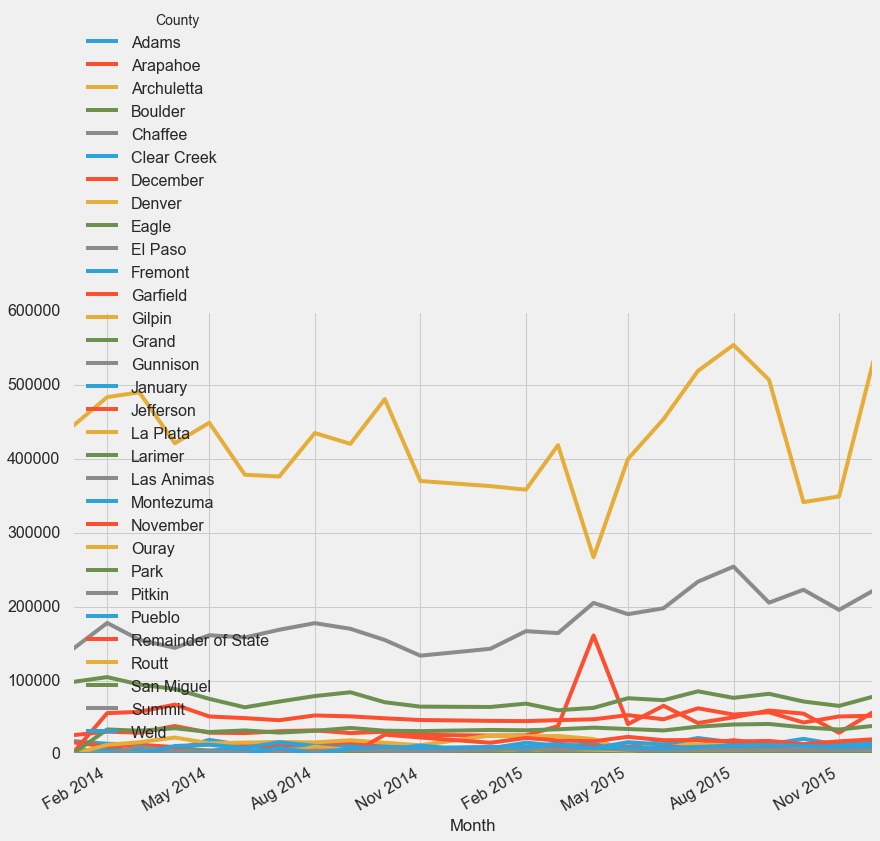

In [233]:
medical_df = df['Medical Marijuana'].reset_index()

medical_df = medical_df.pivot(index='Month',columns='County',values='Medical Marijuana').fillna(0)

medical_df.plot()
#Definitely less cyclical here...

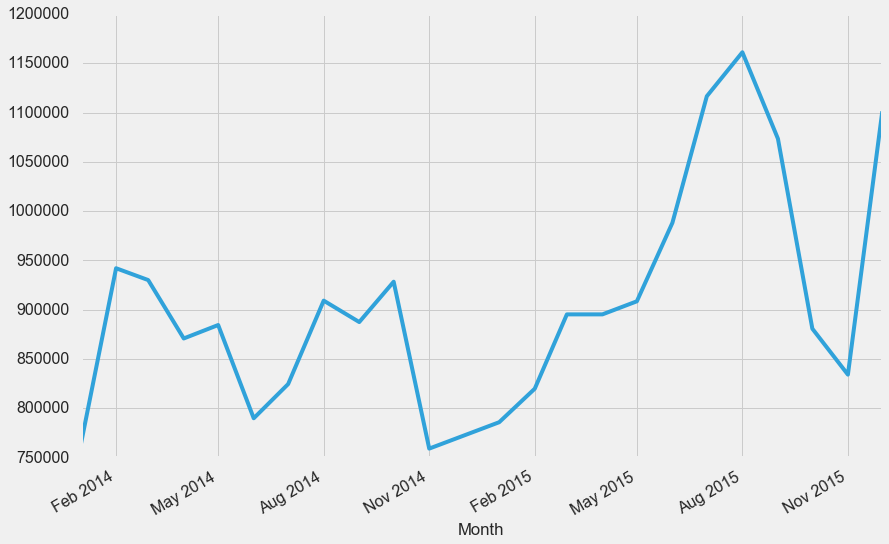

In [242]:

medical_df.sum(axis=1).plot()

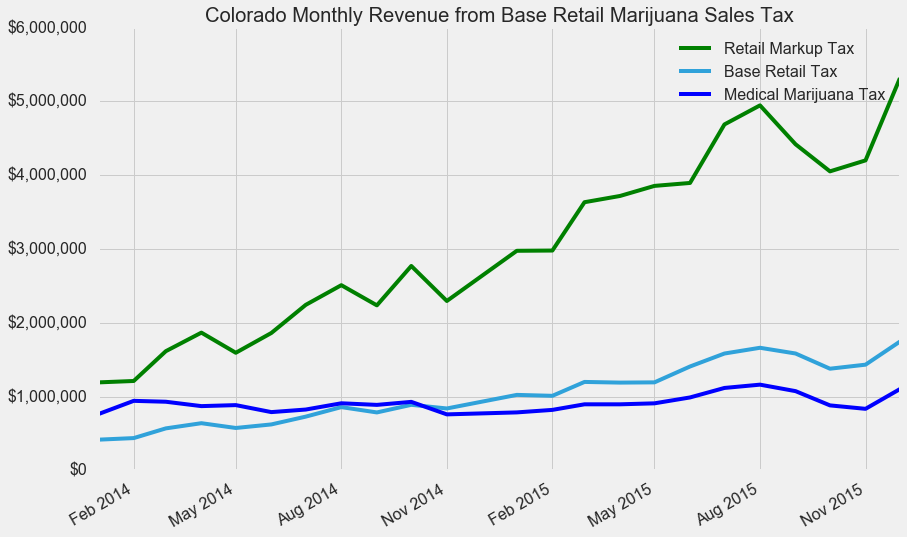

In [275]:
addl_series.sum(axis=1).plot(color='green',label='Retail Markup Tax')
retail_series.sum(axis=1).plot(label='Base Retail Tax')
medical_df.sum(axis=1).plot(color='blue',label='Medical Marijuana Tax')
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
plt.xlabel('')
plt.title("Colorado Monthly Revenue from Base Retail Marijuana Sales Tax")
plt.legend()